In [1]:
import numpy as np
from numpy.ma.core import ceil
from scipy.spatial import distance
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from matplotlib import animation, colors
from matplotlib.colors import ListedColormap

In [2]:
from sklearn.datasets import load_iris

In [3]:
X, y = load_iris(return_X_y=True)

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(120, 4) (120,) (30, 4) (30,)


In [5]:
def e_distance(x,y):
  return distance.euclidean(x,y)

In [6]:
def m_distance(x,y):
  return distance.cityblock(x,y)

In [7]:
def winning_neuron(data, t, som, num_rows, num_cols):
  winner = [0,0]
  shortest_distance = np.sqrt(data.shape[1]) # initialise with max distance
  input_data = data[t]
  for row in range(num_rows):
    for col in range(num_cols):
      distance = e_distance(som[row][col], data[t])
      if distance < shortest_distance: 
        shortest_distance = distance
        winner = [row,col]
  return winner

In [8]:
def decay(step, max_steps,max_learning_rate,max_m_distance):
  coefficient = 1.0 - (np.float64(step)/max_steps)
  learning_rate = coefficient*max_learning_rate
  neighbourhood_range = ceil(coefficient * max_m_distance)
  return learning_rate, neighbourhood_range

In [9]:
# hyperparameters
# We could use the [5 * sqrt(number of training samples)] formula
num_rows = 8
num_cols = 8
# The initial value for the maximum neighbourhood range and learning rate can be set
# with a large number. If the rates are too small, it may result in overfitting and
# requiring more training steps for the learning.
max_m_distance = 4
max_learning_rate = 0.5
# The number of training steps may require at least (500 * n rows * m columns) to converge. 
max_steps = int(3.2*10e3)

In [10]:
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train) # normalisation

# initialising self-organising map
num_dims = X_train_norm.shape[1] # numnber of dimensions in the input data
np.random.seed(40)
som = np.random.random_sample(size=(num_rows, num_cols, num_dims)) # map construction

# start training iterations
for step in range(max_steps):
  if (step+1) % 1000 == 0:
    print("Iteration: ", step+1) # print out the current iteration for every 1k
  learning_rate, neighbourhood_range = decay(step, max_steps,max_learning_rate,max_m_distance)

  t = np.random.randint(0,X_train_norm.shape[0]) # random index of traing data
  winner = winning_neuron(X_train_norm, t, som, num_rows, num_cols)
  for row in range(num_rows):
    for col in range(num_cols):
      if m_distance([row,col],winner) <= neighbourhood_range:
        som[row][col] += learning_rate*(X_train_norm[t]-som[row][col]) #update neighbour's weight

print("SOM training completed")

Iteration:  1000
Iteration:  2000
Iteration:  3000
Iteration:  4000
Iteration:  5000
Iteration:  6000
Iteration:  7000
Iteration:  8000
Iteration:  9000
Iteration:  10000
Iteration:  11000
Iteration:  12000
Iteration:  13000
Iteration:  14000
Iteration:  15000
Iteration:  16000
Iteration:  17000
Iteration:  18000
Iteration:  19000
Iteration:  20000
Iteration:  21000
Iteration:  22000
Iteration:  23000
Iteration:  24000
Iteration:  25000
Iteration:  26000
Iteration:  27000
Iteration:  28000
Iteration:  29000
Iteration:  30000
Iteration:  31000
Iteration:  32000
SOM training completed


In [11]:
# collecting labels
label_data = y_train
mapp = np.empty(shape=(num_rows, num_cols), dtype=object)

for row in range(num_rows):
    for col in range(num_cols):
        mapp[row][col] = [] # empty list to store the label

for t in range(X_train_norm.shape[0]):
    if (t+1) % 1000 == 0:
        print("sample data: ", t+1)
    winner = winning_neuron(X_train_norm, t, som, num_rows, num_cols)
    mapp[winner[0]][winner[1]].append(label_data[t]) # label of winning neuron

In [12]:
# construct label map
label_map = np.zeros(shape=(num_rows, num_cols),dtype=np.int64)
for row in range(num_rows):
  for col in range(num_cols):
    label_list = mapp[row][col]
    if len(label_list)==0:
      label = 3
    else:
      label = max(label_list, key=label_list.count)
    label_map[row][col] = label

In [13]:
label_map

array([[2, 1, 1, 1, 3, 1, 0, 0],
       [2, 2, 3, 1, 1, 1, 3, 0],
       [2, 1, 3, 1, 1, 3, 0, 0],
       [3, 2, 2, 1, 1, 3, 0, 0],
       [2, 3, 1, 1, 1, 3, 0, 0],
       [2, 1, 1, 2, 2, 1, 0, 0],
       [2, 2, 3, 2, 2, 2, 3, 0],
       [2, 3, 2, 2, 2, 2, 3, 0]])

In [14]:
# test data

# using the trained som, search the winning node of corresponding to the test data
# get the label of the winning node

data = scaler.transform(X_test) # normalisation

winner_labels = []

for t in range(data.shape[0]):
 winner = winning_neuron(data, t, som, num_rows, num_cols)
 row, col = winner[0], winner[1]
 predicted = label_map[row][col]
 winner_labels.append(predicted)

print("Accuracy: ",accuracy_score(y_test, np.array(winner_labels)))

Accuracy:  0.8333333333333334


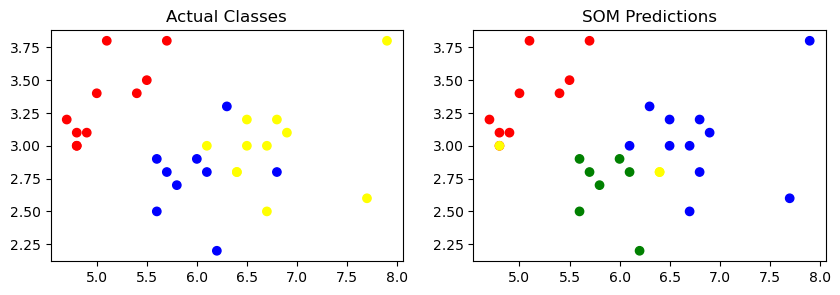

In [15]:
# Plot the results
fig, ax = plt.subplots(ncols=2, figsize=(10,3))
x = X_test[:,0]
y = X_test[:,1]
colors = ['red', 'green', 'blue', 'yellow']
cmapp = ListedColormap(colors)
ax[0].scatter(x, y, c=y_test, cmap=cmapp)
ax[0].title.set_text('Actual Classes')
ax[1].scatter(x, y, c=winner_labels, cmap=cmapp)
ax[1].title.set_text('SOM Predictions')